<h1><center>Computational Finance</center></h1>
<center><br>Omar Jarir</center>

In [1]:
# !pip install numpy_financial
# !pip install pandas_datareader

In [2]:
# Importing the necessary libraries.

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.optimize import minimize
from pprint import pprint
import numpy_financial as npf
import seaborn as sns
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import glob
import os

sns.set_theme(style="whitegrid", palette="dark")

# Setting the print options.
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})

## Exercise 1

<br> a) Build a class called YieldCurve that will receive an array with information on maturity, price and coupon for n=10 bonds (n x 3).
<br> b) Add a method that will bootstrap the discount factors using matrix operations.
<br> c) Add a method that will bootstrap the discount factors using a global solver.
<br> d) Add a method that will bootstrap the discount factors using an iterative procedure.
<br> e) Determine the spot rate (annual compunding) for each maturity from the calculated discount factors and plot them.
<br> f) Determine the YTM for each bond and plot them.
<br> g) Determine the 1y forward rate starting in each of the years from 1 to 9 and plot them.
<br> h) Make a plot of the spot rates, yields and forward rates with a legend identifying the series.

In [3]:
# Building the maturities, the coupon rate and the dirty prices arrays, based on the bond market information 
# for a set of Treasury government bonds provided in the announcement of the project.

maturities = np.arange(1,11)
prices = np.array([ 96.6, 93.71, 91.56, 90.24, 89.74, 90.04, 91.09, 92.82, 95.19, 98.14])
coupons = np.linspace(0.015, 0.0375, num=10)

# Stacking all the arrays in order to form the bonds array, which will be the input of the YieldCurve class.
bonds = np.column_stack((maturities, prices, coupons))

In [4]:
# Building a class called YieldCurve that receives an array with information on maturity, price and coupon 
# for n=10 bonds (n x 3).

class YieldCurve:
   
    def __init__(self, bonds):
        self.bonds = bonds
        # Building the cash flows matrix. 
        cash_flows = [[np.round(100*row[2],2) if n <int(row[0]) else np.round((row[2] + 1)*100, 2)  
               for n in range(1, int(row[0])+1)] +[0]*(self.bonds.shape[0] - int(row[0])) for row in self.bonds]
        self.cash_flows = np.array(cash_flows)        
    
    # Adding a method that bootstrap the discount factors using either matrix operations, global solver or 
    # iterative procedure.
    def DiscountFactors(self, method):
            if method == 'Matrix operations':
                return np.linalg.solve(self.cash_flows, self.bonds[:,1])
            
            elif method == 'Global Solver':
                def BondsPrices(cfs, DF):
                    return cfs@DF
                def error(dfs, cfs, p): return ((BondsPrices(cfs, dfs) - p)**2).sum()
                # Initial guess of the discount factors.
                dfs0 = np.array([1 ,1 ,1 ,1, 1, 1, 1, 1, 1, 1])
                return minimize(error , dfs0, args=(y.cash_flows, y.bonds[:,1]))['x']
            
            elif method == 'Iterative Procedure':
                tmp = []
                for row in self.bonds:
                    tmp.append((row[1] - 100*row[2]*sum(tmp))/(100*(row[2] + 1))) 
                return np.array(tmp)
                
    # Determining the spot rate (annual compounding) for each maturity from the calculated discount factors,
    # using the Matrix operations method. 
    def SpotRates(self):
        tmp = self.DiscountFactors('Matrix operations')
        Srates = np.power(1./tmp, 1/np.arange(1, self.bonds.shape[0] + 1)) - 1
        return Srates
    
    # Determing the YTM for each bond using the function npf.irr from the numpy_financial package.
    def BondsYtm(self):
        Ytm = np.array([npf.irr([-row[1]]+[row[2]*100 if n < int(row[0]) else (row[2] + 1)*100 
                    for n in range(1,int(row[0]) +1)]) for row in self.bonds])        
        return Ytm
         
    # Determining the 1y forward rate starting in each of the years from 1 to 9, 
    def ForwardRates(self):
        Srate = self.SpotRates() 
        # Using the formula on page 17, on interest rates slides.
        Frate = Srate[1:]*y.bonds[1:, 0] - (Srate[:]*y.bonds[:, 0])[:-1]          
        return Frate

In [5]:
# defining an object instance of the YieldCurve class.
y = YieldCurve(bonds)

__b) Add a method that will bootstrap the discount factors using matrix operations.__

In [6]:
print('Discount factor using matrix operations\n', y.DiscountFactors('Matrix operations'))
print('Original prices vector\n', y.bonds[:,1])
print('Verified prices with discount factor should the same as original price\n',
      y.cash_flows@y.DiscountFactors('Matrix operations'))


Discount factor using matrix operations
 [0.9517 0.9046 0.8612 0.8227 0.7892 0.7604 0.7361 0.7156 0.6985 0.6842]
Original prices vector
 [96.6000 93.7100 91.5600 90.2400 89.7400 90.0400 91.0900 92.8200 95.1900
 98.1400]
Verified prices with discount factor should the same as original price
 [96.6000 93.7100 91.5600 90.2400 89.7400 90.0400 91.0900 92.8200 95.1900
 98.1400]


__c) Add a method that will bootstrap the discount factors using a global solver.__

In [7]:
print('Discount factor using a global solver\n', y.DiscountFactors('Global Solver'))
print('Original prices vector\n', y.bonds[:,1])
print('Verified prices with discount factor should the same as original price\n', 
      y.cash_flows@y.DiscountFactors('Global Solver'))

Discount factor using a global solver
 [0.9517 0.9046 0.8612 0.8227 0.7892 0.7604 0.7361 0.7156 0.6985 0.6842]
Original prices vector
 [96.6000 93.7100 91.5600 90.2400 89.7400 90.0400 91.0900 92.8200 95.1900
 98.1400]
Verified prices with discount factor should the same as original price
 [96.6000 93.7100 91.5600 90.2400 89.7400 90.0400 91.0900 92.8200 95.1900
 98.1400]


__d) Add a method that will bootstrap the discount factors using an iterative procedure.__

In [8]:
print('Discount factor using an iterative procedure\n', y.DiscountFactors('Iterative Procedure'))
print('Original prices vector\n', y.bonds[:,1])
print('Verified prices with discount factor should be the same as original price\n', 
      y.cash_flows@y.DiscountFactors('Iterative Procedure'))

Discount factor using an iterative procedure
 [0.9517 0.9046 0.8612 0.8227 0.7892 0.7604 0.7361 0.7156 0.6985 0.6842]
Original prices vector
 [96.6000 93.7100 91.5600 90.2400 89.7400 90.0400 91.0900 92.8200 95.1900
 98.1400]
Verified prices with discount factor should be the same as original price
 [96.6000 93.7100 91.5600 90.2400 89.7400 90.0400 91.0900 92.8200 95.1900
 98.1400]


__e) Ploting the Spot Rates.__

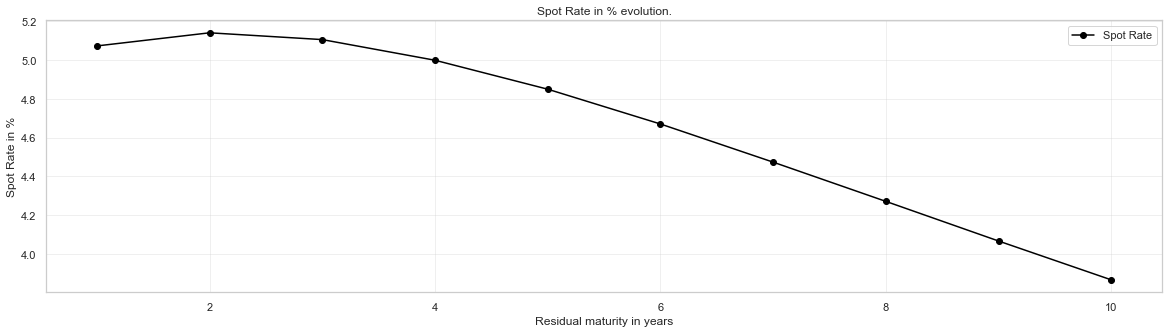

In [9]:
# Ploting the Spot Rate for each maturity.
Srates = y.SpotRates()

plt.figure(figsize=(20,5))
plt.plot(y.bonds[:,0],100*Srates,color='black',marker='o',mec='black',label='Spot Rate') 
plt.grid(alpha=0.3)
plt.xlabel('Residual maturity in years')
plt.ylabel('Spot Rate in %')
plt.title('Spot Rate in % evolution.')
plt.legend()
plt.show();

__f) Ploting the Ytm.__

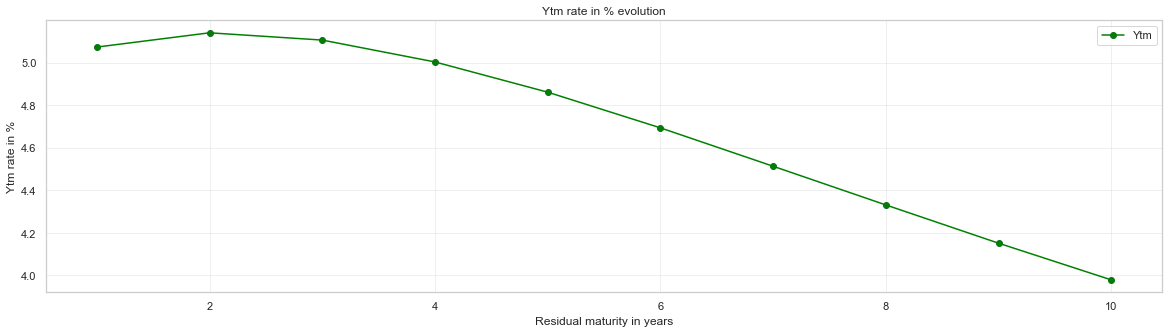

In [10]:
# Ploting the Yield to maturity for each bond.
Ytm = y.BondsYtm()

plt.figure(figsize=(20,5))
plt.plot(y.bonds[:,0],100*Ytm,color='green',marker='o',mec='g',label='Ytm') 
plt.grid(alpha=0.3)
plt.xlabel('Residual maturity in years')
plt.ylabel('Ytm rate in %')
plt.title('Ytm rate in % evolution')
plt.legend()
plt.show();

__g) Ploting the forward rates.__

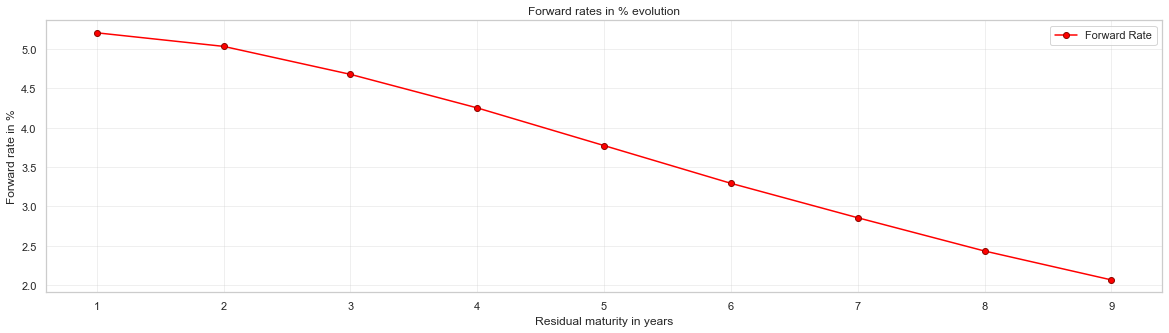

In [11]:
# Ploting the forward rates.
Frate = y.ForwardRates()

plt.figure(figsize=(20,5))
plt.plot(y.bonds[:-1,0],100*Frate,color='red',marker='o',mec='r',label='Forward Rate') 
plt.grid(alpha=0.3)
plt.xlabel('Residual maturity in years')
plt.ylabel('Forward rate in %')
plt.title('Forward rates in % evolution')
plt.legend()
plt.show();

__h) Make a plot of the spot rates, yields and forward rates with a legend identifying the series__

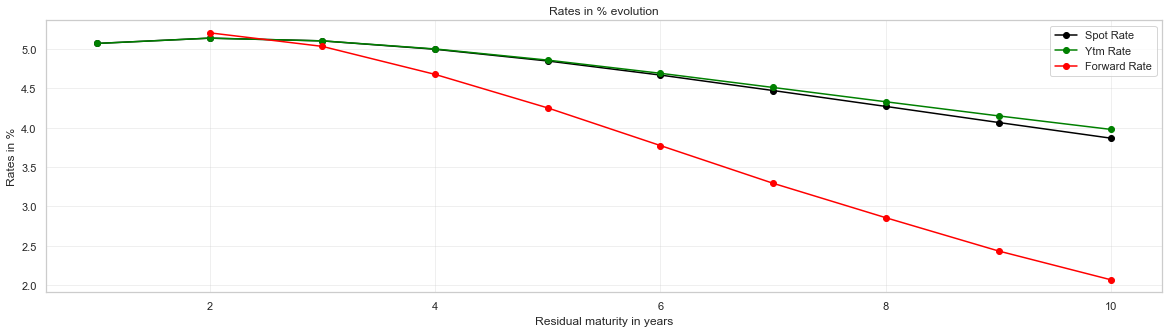

In [12]:
# Plotting all rates together.

Srates = y.SpotRates()
Ytm = y.BondsYtm()
Frate = y.ForwardRates()

plt.figure(figsize=(20,5))
plt.plot(y.bonds[:,0],100*Srates,color='black',marker='o',mec='black',label ='Spot Rate')
plt.plot(y.bonds[:,0],100*Ytm,color='green',marker='o',mec='green',label ='Ytm Rate')
plt.plot(y.bonds[1:,0],100*Frate,color='red',marker='o',mec='red',label ='Forward Rate')
plt.grid(alpha=0.3)
plt.xlabel('Residual maturity in years')
plt.ylabel('Rates in %')
plt.title('Rates in % evolution')
plt.legend()
plt.show();

## Exercise 2

__a) Getting the historical data (close price and volume) for the following 5 stocks (Apple, IBM, Microsoft, Google, Facebook) using the pandas_datareader API, since the 1st January of 2012, till today.__

In [13]:
# Using the pandas_datareader API to get the historical data.
tickers = ['AAPL', 'IBM', 'MSFT', 'GOOG', 'AMZN']
all_data = {ticker: pdr.get_data_yahoo(ticker, start=datetime(2012, 1, 1))\
            for ticker in tickers}

In [14]:
# Close price and volume dataframes, droping the empty values.

price = pd.DataFrame({ticker: data['Close'] for ticker, data in all_data.items()}) 
volume = pd.DataFrame({ticker: data['Volume'].astype(int) for ticker, data in all_data.items()})

In [15]:
# Concatinating the price and volume dataframes.

df = pd.concat([price, volume], keys=['price', 'volume'], axis=1) 
df.head()

price                                               volume  \
                 AAPL         IBM       MSFT       GOOG    AMZN       AAPL   
Date                                                                         
2012-01-03  14.686786  178.107071  26.770000  16.573130  8.9515  302220800   
2012-01-04  14.765714  177.380493  27.400000  16.644611  8.8755  260022000   
2012-01-05  14.929643  176.539200  27.680000  16.413727  8.8805  271269600   
2012-01-06  15.085714  174.512421  28.110001  16.189817  9.1305  318292800   
2012-01-09  15.061786  173.604202  27.740000  15.503389  8.9280  394024400   

                                                     
                IBM      MSFT       GOOG       AMZN  
Date                                                 
2012-01-03  5905716  64731500  147611217  102216000  
2012-01-04  4546648  80516100  114989399   84104000  
2012-01-05  4668403  56081400  131808205   76182000  
2012-01-06  5122367  99455500  108119746  140168000  
2012-01-09  5440455  59706800  233776981  101138000

__b) Ploting the cumulative returns of the stocks on a single chart.__

In [16]:
# Returns of the stocks.

returns = price.pct_change().dropna()
returns.head()

,AAPL,IBM,MSFT,GOOG,AMZN
Date,,,,,
2012-01-04,0.005374,-0.004079,0.023534,0.004313,-0.008490
2012-01-05,0.011102,-0.004743,0.010219,-0.013871,0.000563
2012-01-06,0.010454,-0.011481,0.015535,-0.013642,0.028152
2012-01-09,-0.001586,-0.005204,-0.013163,-0.042399,-0.022178
2012-01-10,0.003580,-0.001542,0.003605,0.001092,0.004368


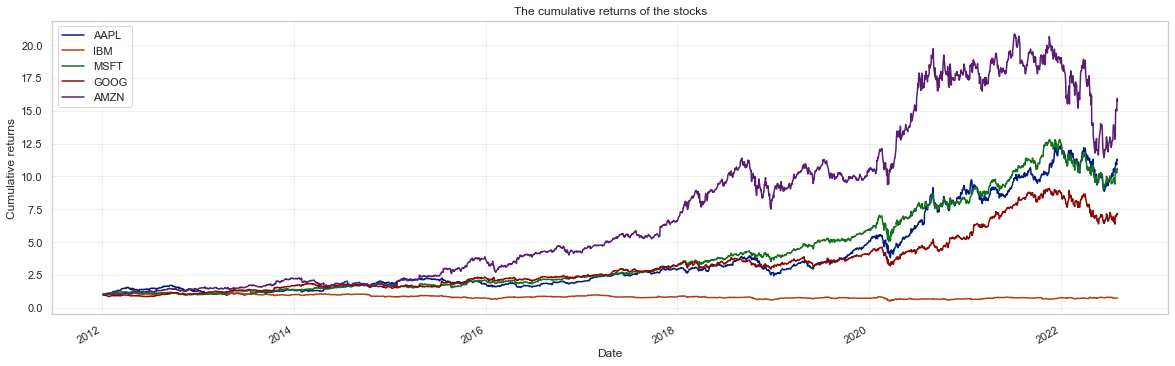

In [23]:
# The cumulative returns of the stocks

fig, ax = plt.subplots(figsize=(20,6))
(returns + 1).cumprod().plot(title='The cumulative returns of the stocks', ax=ax) 
ax.set_ylabel('Cumulative returns')
ax.grid(alpha=0.3)
plt.show();

__c) Creating the correlation matrix of the daily returns.__

In [18]:
# The correlation matrix of the daily returns.

returns.corr().style.background_gradient(cmap='viridis')

,AAPL,IBM,MSFT,GOOG,AMZN
AAPL,1.000000,0.376545,0.583687,0.539147,0.469721
IBM,0.376545,1.000000,0.451770,0.397143,0.282689
MSFT,0.583687,0.451770,1.000000,0.647222,0.556929
GOOG,0.539147,0.397143,0.647222,1.000000,0.594897
AMZN,0.469721,0.282689,0.556929,0.594897,1.000000


__d) Saving the data (close price and volume) to a csv file for each ticker.__

In [19]:
# The Concatinated dataframe containing the prices and volumes.

df.head()

price                                               volume  \
                 AAPL         IBM       MSFT       GOOG    AMZN       AAPL   
Date                                                                         
2012-01-03  14.686786  178.107071  26.770000  16.573130  8.9515  302220800   
2012-01-04  14.765714  177.380493  27.400000  16.644611  8.8755  260022000   
2012-01-05  14.929643  176.539200  27.680000  16.413727  8.8805  271269600   
2012-01-06  15.085714  174.512421  28.110001  16.189817  9.1305  318292800   
2012-01-09  15.061786  173.604202  27.740000  15.503389  8.9280  394024400   

                                                     
                IBM      MSFT       GOOG       AMZN  
Date                                                 
2012-01-03  5905716  64731500  147611217  102216000  
2012-01-04  4546648  80516100  114989399   84104000  
2012-01-05  4668403  56081400  131808205   76182000  
2012-01-06  5122367  99455500  108119746  140168000  
2012-01-09  5440455  59706800  233776981  101138000

In [20]:
# Saving the price and volume in a csv file for each ticker.
for ticker in tickers:
    df.iloc[:, df.columns.get_level_values(1)== ticker].droplevel(1, axis=1).\
    to_csv(f'{ticker}.csv')

In [21]:
# Checking if it worked.

DfLists = []

for ticker in tickers:
    DfLists.append(pd.read_csv(ticker+'.csv', index_col = 'Date'))
    
AAPL, IBM, MSFT, GOOG, AMZN = DfLists
IBM.head()

,price,volume
Date,,
2012-01-03,178.107071,5905716
2012-01-04,177.380493,4546648
2012-01-05,176.539200,4668403
2012-01-06,174.512421,5122367
2012-01-09,173.604202,5440455


__e) Loading the data from the CSV files and saving it into single DataFrame with the prices for each ticker.__

In [22]:
# Loading the data for all the CSV files into a dataframe with prices for each ticker.

DfFromEachFile = (pd.read_csv(f'{ticker}.csv', usecols= ['Date', 'price'], index_col= 'Date') for ticker in tickers)
price = pd.concat(DfFromEachFile, axis=1)
price.columns = tickers
price.head()

,AAPL,IBM,MSFT,GOOG,AMZN
Date,,,,,
2012-01-03,14.686786,178.107071,26.770000,16.573130,8.9515
2012-01-04,14.765714,177.380493,27.400000,16.644611,8.8755
2012-01-05,14.929643,176.539200,27.680000,16.413727,8.8805
2012-01-06,15.085714,174.512421,28.110001,16.189817,9.1305
2012-01-09,15.061786,173.604202,27.740000,15.503389,8.9280
